# DCGAN with MNIST

## model

In [24]:
import argparse
import os
import numpy as np
import math

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch


import matplotlib.pyplot as plt

In [27]:
class hyperparameters:
  n_epochs = 50
  img_size = 32
  batch_size = 128
  lr = 0.0002
  b1 = 0.5
  b2 = 0.999
  latent_dim = 100
  channels = 1
  sample_interval = 400

opt = hyperparameters()

def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.init_size = opt.img_size // 4
        self.l1 = nn.Sequential(nn.Linear(opt.latent_dim, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, opt.channels, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, z):
        out = self.l1(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, bn=True):
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1), nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.25)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.model = nn.Sequential(
            *discriminator_block(opt.channels, 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )

        # The height and width of downsampled image
        ds_size = opt.img_size // 2 ** 4
        self.adv_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, 1), nn.Sigmoid())

    def forward(self, img):
        out = self.model(img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)

        return validity

### pare GPU

In [26]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
!nvidia-smi

cuda = True if torch.cuda.is_available() else False

True
1
Wed Mar  1 10:38:43 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0    32W /  70W |   1729MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+

### datasets

torch.Size([1, 32, 32])
0


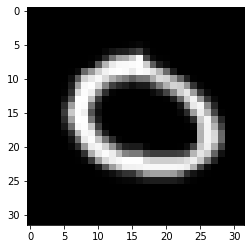

In [17]:
dataloader = torch.utils.data.DataLoader(
    dataset=datasets.MNIST(
        root='./data',
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.Resize(opt.img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=opt.batch_size,
    shuffle=True,
)

# show a example data
index = 10

dataiter = iter(dataloader)
(img, label) = next(dataiter)

print(img[0].shape)
print(label[index].item())

plt.imshow(img[index].squeeze(), cmap='gray')

## define hyperparameter

In [28]:
# Loss function
adversarial_loss = torch.nn.BCELoss()

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

In [29]:
Generator_PATH = './Gmodel'
Discriminator_PATH = './Dmodel'

# generator.load_state_dict(torch.load(Generator_PATH))
# discriminator.load_state_dict(torch.load(Discriminator_PATH))

In [30]:
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

for epoch in range(opt.n_epochs):
    for i, (imgs, _) in enumerate(dataloader):

        # Adversarial ground truths
        valid = Variable(Tensor(imgs.shape[0], 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.shape[0], 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(Tensor))

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], opt.latent_dim))))

        # Generate a batch of images
        gen_imgs = generator(z)

        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        batches_done = epoch * len(dataloader) + i
        # if batches_done % opt.sample_interval == 0:
        #     save_image(gen_imgs.data[:25], "images/%d.png" % batches_done, nrow=5, normalize=True)
    if epoch % 10 == 0:
      print(
          "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
          % (epoch, opt.n_epochs, i, len(dataloader), d_loss.item(), g_loss.item())
      )



torch.save(generator.state_dict(), Generator_PATH)
torch.save(discriminator.state_dict(), Discriminator_PATH)

[Epoch 0/50] [Batch 468/469] [D loss: 0.694046] [G loss: 0.691948]
[Epoch 10/50] [Batch 468/469] [D loss: 0.497294] [G loss: 0.747374]
[Epoch 20/50] [Batch 468/469] [D loss: 0.411432] [G loss: 0.904217]


KeyboardInterrupt: ignored

In [32]:
torch.save(generator.state_dict(), Generator_PATH)
torch.save(discriminator.state_dict(), Discriminator_PATH)

## test

torch.Size([1, 32, 32])


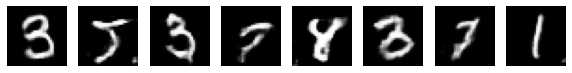

In [31]:
with torch.no_grad():
  # Sample noise as generator input
  z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], opt.latent_dim))))

  # Generate a batch of images
  gen_imgs = generator(z)
  gen_imgs = gen_imgs.cpu()

  print(gen_imgs[0].shape)

  fig, axes = plt.subplots(nrows=1, ncols=8, figsize=(10,5))

  for i, ax in enumerate(axes):
      ax.imshow(gen_imgs[i].squeeze(), cmap='gray')
      ax.axis('off')
